# SAE 2.04 - Documentation Technique

***Tilian HURÉ (4A)***

**Note :** Par manque de temps et de connaissance en la librairie `Matplotlib`, seul les graphiques et les schémas seront élaborés avec du code `python`. <br>
Les légendes et autres données supplémentaires seront ajoutées par édition externe pour plus de possiblité de customisation et en moins de temps.

## Importation des librairies

Certaines librairies python sont primordiales pour obtenir, manipuler et rendre visualisable les données souhaitées.

Librairies utilisées :
* `matplotlib` pour la création des schémas visuelles
* `numpy` pour la manipulation et le formatage de certaines données
* `cx_Oracle` pour se connecter à une base données et récupérer les données souhaitées via des requêtes SQL-LID
* `random` pour réaliser certains choix de manière alétoire (nombres, couleurs, etc)

In [456]:
import matplotlib.pyplot as plt
import numpy as np
import cx_Oracle
from random import randint


## Connexion à la base de données Oracle

La première étape consiste à se connecter à la base de données Oracle sur laquelle se trouve les données sur lesquelles vons se baser les schémas et graphiques qui vont suivre.

In [457]:
# Données de connexion du DNS
dsn = cx_Oracle.makedsn(host='oracle.iut-blagnac.fr', port=1521, sid='db11g')


# Données de connexion à la base de données (avec les données du DNS)
connexion = cx_Oracle.connect(user = "SAEBD43", 
                               password = "Anet0IUT",
                               dsn = dsn,
                               encoding = "UTF-8")


# Création d'un curseur avec la connexion à la base de données
curseur = connexion.cursor()

## Fonctions utiles

Quelques fonctions utiles pouvant être utilisées dans le traitement de données et la mise en forme des schémas.

In [458]:
def get_random_hexa_color():
    """:return: une couleur hexadécimale générée aléatoirement"""
    return '#'+''.join(hex(randint(0, 15)).replace('0x', '') for i in range(6)).upper()

## Scripts

Scripts SQL-LID d'interrogation de la base de données, ainsi que le code python nécessaire pour formater et rendre les données récupérées visualisables sous la forme de schémas adaptés.

### Nombres de clients

Données générales sur les clients :
* Nombre de clients total
* Nombre de clients ayant réalisé une ou plus commande
* Nombre de clients n'ayant pas réalisé de commande

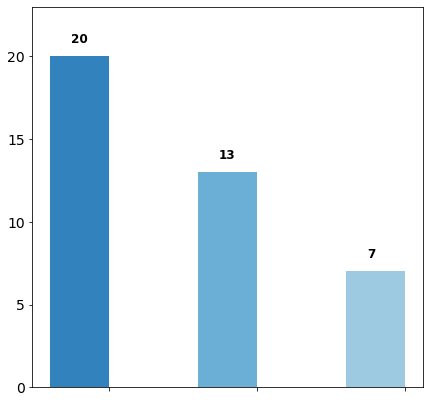

In [459]:
# Requêtes SQL-LID
curseur.execute("SELECT COUNT(numClient) FROM Client") # nombre de clients total
nbClients = [list(curseur)[0][0]]

curseur.execute(
    "SELECT COUNT(numClient) FROM Client \
    WHERE numClient IN ( \
        SELECT numClient FROM Client \
        INTERSECT \
        SELECT numClient FROM Commande)") # nombre de clients ayant commandé
nbClients.append(list(curseur)[0][0])

curseur.execute(
    "SELECT COUNT(numClient) FROM Client \
    WHERE numClient IN ( \
        SELECT numClient FROM Client \
        MINUS \
        SELECT numClient FROM Commande)") # nombre de clients sans commande
nbClients.append(list(curseur)[0][0])

    ##print(nbClients)


# Définition des propriétés visuelles du diagramme en bâton
colormap = plt.get_cmap('tab20c') # palette de couleurs
colors = [colormap(i) for i in range(len(nbClients))]


# Initialisation du diagramme en bâton
plt.subplots(figsize=(7, 7)) # création du schéma
plt.ylim(0, 23)
X_axis = np.arange(len(nbClients))
plt.xticks(X_axis, [], fontsize=12)
plt.yticks(fontsize=14)

plt.bar(X_axis-0.2, nbClients, 0.4, label='Nombre de clients', color=colors) # création du diagramme en bâton

for i, ca in enumerate(nbClients): # pourcentages des bâtons
    plt.text(i-0.255, ca+0.85, ca, fontweight='bold', fontsize=12)


# Sauvegarde et affichage du schéma
plt.savefig("graphics/nbClients.svg", bbox_extra_artists=(legend,), bbox_inches='tight', transparent=True)
plt.show()

### Montant des ventes par pays

Montants totaux de toutes les commandes en fonction des pays des clients ayant passé au moins une commande.

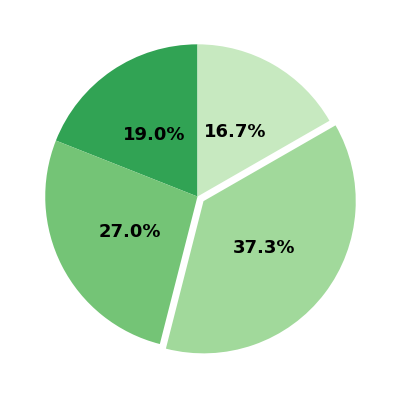

In [460]:
# Requête SQL-LID
curseur.execute(
    "SELECT ROUND(SUM(CO.montantTTC)) AS Montant_ventes, C.adrPaysClient AS Pays \
    FROM Commande CO, Client C, Etiquette E \
    WHERE C.codeEtiquette = E.codeEtiquette \
    AND CO.numClient = C.numClient \
    GROUP BY C.adrPaysClient, E.codeTypeTVA \
    ORDER BY Pays DESC")


# Récupération des données
donnees = list(curseur)[:] # copie du curseur
montantVentes = [mv[0] for mv in donnees]
pays = [p[1] for p in donnees]
    ##print(donnees, montantVentes, pays)

    
# Définition des propriétés visuelles de la tarte graphique
explodes = [0, 0, 0.05, 0] ## + [0 for i in range(len(donnees)-1)] # 'explosures' de la tarte
colormap = plt.get_cmap('tab20c') # palette de couleurs
colors = [colormap(i+8) for i in range(len(donnees))]

    
# Initialisation de la tarte graphique
plt.subplots(figsize=(7, 7)) # création du schéma
plt.pie(montantVentes, wedgeprops={'linewidth':0, 'edgecolor':"white"},
         autopct='%1.1f%%', shadow=False, startangle=90,
         textprops={'color':'black', 'size':18, 'fontweight':'bold'}, colors=colors,
         explode=explodes, pctdistance=0.5) #création de la tarte


# Sauvegarde et affichage du schéma
plt.savefig("graphics/ventesParPays.svg", bbox_extra_artists=(legend,), bbox_inches='tight', transparent=True)
plt.show()

### Meilleurs clients par pays

Clients avec les plus gros chiffres d'affaires parmi tous les clients de leurs pays.

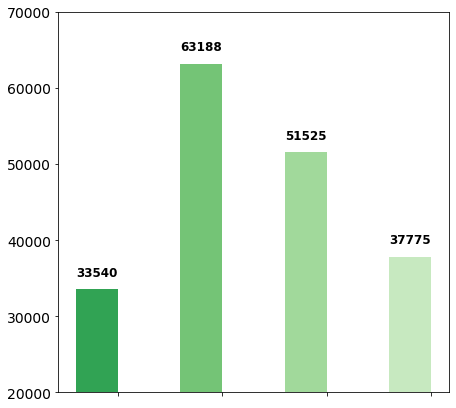

In [461]:
# Requêtes SQL-LID
curseur.execute(
    "SELECT C.adrPaysClient AS Pays, C.nomClient AS Client, ROUND(SUM(CO.montantTTC)) AS Montant_ventes \
    FROM Client C, Commande CO \
    WHERE CO.numClient = C.numClient \
    GROUP BY C.adrPaysClient, C.nomClient, C.codeEtiquette \
    HAVING ROUND(SUM(CO.montantTTC)) >= ALL ( \
        SELECT ROUND(SUM(CO2.montantTTC)) AS Montant_ventes \
        FROM Client C2, Commande CO2, Etiquette E2 \
        WHERE C2.codeEtiquette = C.codeEtiquette \
        AND CO2.numClient = C2.numClient \
        AND E2.codeEtiquette = C2.codeEtiquette \
        GROUP BY C2.nomClient, E2.codeTypeTVA) \
    ORDER BY Pays DESC")


# Récupération des données
donnees = list(curseur)[:] # copie du curseur
clients = [client[1] for client in donnees]
chiffresAffaires = [ca[2] for ca in donnees]
    ##print(donnees, clients, chiffresAffaires)


# Affichage dans la console
def afficher1():
    print('Meilleurs clients par pays :')
    for client in donnees:
        print('Pays :', client[0], '\n    - Meilleur client :', client[1], '\n    - Chiffre d\'affaire :', client[2])
        
    ##afficher1()
    

# Définition des propriétés visuelles du diagramme en bâton
colormap = plt.get_cmap('tab20c') # palette de couleurs
colors = [colormap(i+8) for i in range(len(donnees))]


# Initialisation du diagramme en bâton
plt.subplots(figsize=(7, 7)) # création du schéma
plt.ylim(20000, 70000)
X_axis = np.arange(len(clients))
plt.xticks(X_axis, [], fontsize=12)
plt.yticks(fontsize=14)

plt.bar(X_axis-0.2, chiffresAffaires, 0.4, label='Chiffres d\'affaires', color=colors) # création du diagramme en bâton

for i, ca in enumerate(chiffresAffaires): # pourcentages des bâtons
    plt.text(i-0.4, ca+10**3.25, ca, fontweight='bold', fontsize=12)


# Sauvegarde et affichage du schéma
plt.savefig("graphics/clientsParPays.svg", bbox_extra_artists=(legend,), bbox_inches='tight', transparent=True)
plt.show()

### Catégories les plus sollicitées par pays

Catégories concernées par les articles les plus achetés dans les pays des clients ayant réalisé au moins une commande.

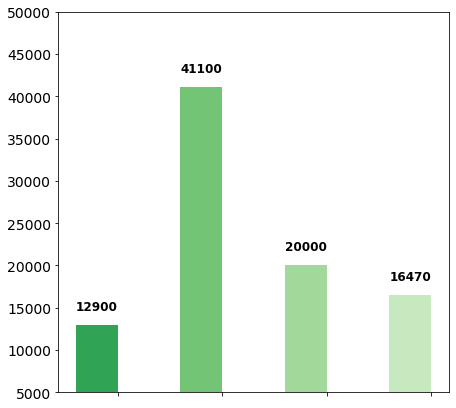

In [462]:
# Requêtes SQL-LID
curseur.execute(
    "SELECT C.adrPaysClient AS Pays, CA.libelleCategorie AS Categorie, \
        ROUND(SUM(TV.prixVente * DC.quantiteCommandee)) AS Montant_ventes \
    FROM Client C, Categorie CA, Commande CO, Detail_Commande DC, Article A, Tarif_Vente TV \
    WHERE CO.numClient = C.numClient \
    AND DC.numCommande = CO.numCommande \
    AND A.numArticle = DC.numArticle \
    AND CA.numCategorie = A.numCategorie \
    AND TV.numArticle = A.numArticle \
    GROUP BY C.adrPaysClient, CA.libelleCategorie, TV.prixVente, DC.quantiteCommandee, C.codeEtiquette \
    HAVING ROUND(SUM(TV.prixVente * DC.quantiteCommandee)) >= ALL ( \
        SELECT ROUND(SUM(TV2.prixVente * DC2.quantiteCommandee)) AS Montant_ventes \
        FROM Client C2, Categorie CA2, Commande CO2, Detail_Commande DC2, Article A2, Tarif_Vente TV2 \
        WHERE C2.codeEtiquette = C.codeEtiquette \
        AND CO2.numClient = C2.numClient \
        AND DC2.numCommande = CO2.numCommande \
        AND A2.numArticle = DC2.numArticle \
        AND CA2.numCategorie = A2.numCategorie \
        AND TV2.numArticle = A2.numArticle \
        GROUP BY CA.libelleCategorie, A2.numArticle, TV2.prixVente, DC2.quantiteCommandee) \
    ORDER BY Pays DESC")


# Récupération des données
donnees = list(curseur)[:] # copie du curseur
categories = [cat[1] for cat in donnees]
montantVentes = [mv[2] for mv in donnees]
    ##print(donnees, categories, montantVentes)


# Affichage dans la console
def afficher2():
    print('Catégories les plus sollicitées par pays :')
    for categorie in donnees:
        print('Pays :', categorie[0], '\n    - Catégorie la plus sollicitée :', categorie[1], '\n    - Montant des ventes total :', categorie[2])
        
    ##afficher2()
    
    
# Définition des propriétés visuelles du diagramme en bâton
colormap = plt.get_cmap('tab20c') # palette de couleurs
colors = [colormap(i+8) for i in range(len(donnees))]


# Initialisation du diagramme en bâton
plt.subplots(figsize=(7, 7)) # création du schéma
plt.ylim(5000, 50000)
X_axis = np.arange(len(categories))
plt.xticks(X_axis, [], fontsize=12)
plt.yticks(fontsize=14)

plt.bar(X_axis-0.2, montantVentes, 0.4, label='Montant des ventes total', color=colors) # création du diagramme en bâton

for i, mv in enumerate(montantVentes): # pourcentages des bâtons
    plt.text(i-0.4, mv+10**3.25, mv, fontweight='bold', fontsize=12)


# Sauvegarde et affichage du schéma
plt.savefig("graphics/categoriesParPays.svg", bbox_extra_artists=(legend,), bbox_inches='tight', transparent=True)
plt.show()

### Montants des ventes par catégorie

Montants totaux des articles commandés pour chaque catégories.

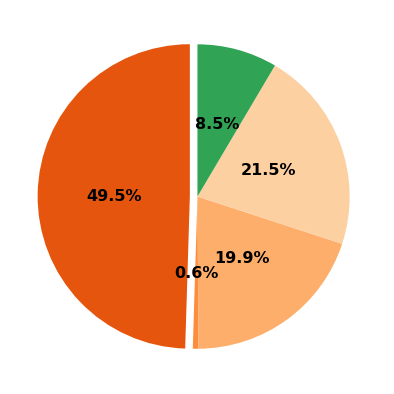

In [463]:
# Requête SQL-LID
curseur.execute(
    "SELECT Ca.libelleCategorie AS Categorie, ROUND(SUM(TV.prixVente * DC.quantiteCommandee)) AS Montant_ventes \
    FROM Article A, Detail_Commande DC, Categorie Ca, Commande CO, Tarif_vente TV \
    WHERE A.numArticle = DC.numArticle \
    AND CA.numCategorie = A.numCategorie \
    AND CO.numCommande = DC.numCommande \
    AND TV.numArticle = A.numArticle \
    GROUP BY Ca.libelleCategorie \
    ORDER BY Categorie DESC")


# Récupération des données
donnees = list(curseur)[:] # copie du curseur
categories = [cat[0] for cat in donnees]
montantVentes = [mv[1] for mv in donnees]
    ##print(donnees, montantVentes, categories)

    
# Définition des propriétés visuelles de la tarte graphique
explodes = [0.05] + [0 for i in range(len(donnees)-1)] # 'explosures' de la tarte
colormap = plt.get_cmap('tab20c') # palette de couleurs
colors = [colormap(i+4) for i in range(len(donnees))]

    
# Initialisation de la tarte graphique
plt.subplots(figsize=(7, 7)) # création du schéma
plt.pie(montantVentes, wedgeprops={'linewidth':0, 'edgecolor':"white"},
         autopct='%1.1f%%', shadow=False, startangle=90, colors=colors,
         textprops={'color':'black', 'size':16, 'fontweight':'bold'},
         explode=explodes, pctdistance=0.5) #création de la tarte


# Sauvegarde et affichage du schéma
plt.savefig("graphics/ventesParCategorie.svg", bbox_extra_artists=(legend,), bbox_inches='tight', transparent=True)
plt.show()

### Articles les plus vendus par catégories

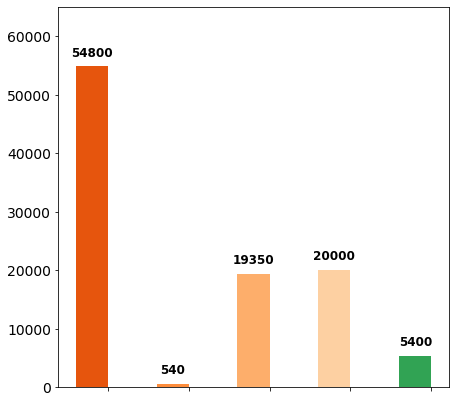

In [464]:
# Requêtes SQL-LID
curseur.execute(
    "SELECT CA.libelleCategorie AS Categorie, A.nomArticle, ROUND(SUM(TV.prixVente * DC.quantiteCommandee)) AS Montant_ventes \
    FROM Article A, Categorie CA, Detail_Commande DC, Tarif_vente TV \
    WHERE CA.numCategorie = A.numCategorie \
    AND DC.numArticle = A.numArticle \
    AND TV.numArticle = A.numArticle \
    GROUP BY CA.libelleCategorie, A.nomArticle, A.numCategorie, TV.prixVente, DC.quantiteCommandee \
    HAVING ROUND(SUM(TV.prixVente * DC.quantiteCommandee)) >= ALL ( \
        SELECT ROUND(SUM(TV2.prixVente * DC2.quantiteCommandee)) AS Montant_ventes \
        FROM Article A2, Detail_Commande DC2, Tarif_Vente TV2 \
        WHERE A2.numCategorie = A.numCategorie \
        AND DC2.numArticle = A2.numArticle \
        AND TV2.numArticle = A2.numArticle \
        GROUP BY A2.numArticle, TV2.prixVente, DC2.quantiteCommandee) \
    ORDER BY Categorie DESC")


# Récupération des données
donnees = list(curseur)[:] # copie du curseur
articles = [art[1] for art in donnees]
montantVentes = [mv[2] for mv in donnees]
    ##print(donnees,articles, montantVentes)


# Affichage dans la console
def afficher3():
    print('Articles les plus vendus par catégories :')
    for article in donnees:
        print('Catégorie :', article[0], '\n    - Article le plus vendu :', article[1], '\n    - Montant des ventes total :', article[2])
        
    ##afficher3()
    
    
# Définition des propriétés visuelles du diagramme en bâton
colormap = plt.get_cmap('tab20c') # palette de couleurs
colors = [colormap(i+4) for i in range(len(donnees))]


# Initialisation du diagramme en bâton
plt.subplots(figsize=(7, 7)) # création du schéma
plt.ylim(0, 65000)
X_axis = np.arange(len(articles))
plt.xticks(X_axis, [], fontsize=12)
plt.yticks(fontsize=14)

plt.bar(X_axis-0.2, montantVentes, 0.4, label='Montant des ventes total', color=colors) # création du diagramme en bâton

for i, mv in enumerate(montantVentes): # pourcentages des bâtons
    if mv < 1000:
        plt.text(i-0.36, mv+10**3.25, mv, fontweight='bold', fontsize=12)
    elif mv < 10000:
        plt.text(i-0.4, mv+10**3.25, mv, fontweight='bold', fontsize=12)
    else:
        plt.text(i-0.455, mv+10**3.25, mv, fontweight='bold', fontsize=12)


# Sauvegarde et affichage du schéma
plt.savefig("graphics/articlesParCategorie.svg", bbox_extra_artists=(legend,), bbox_inches='tight', transparent=True)
plt.show()

### Commandes défectueuses sur les trois derniers mois

En suivant les trois défauts de commandes suivant :
* commandes non-livrées
* commandes livrées partiellement
* commandes livrées en trop grand quantité

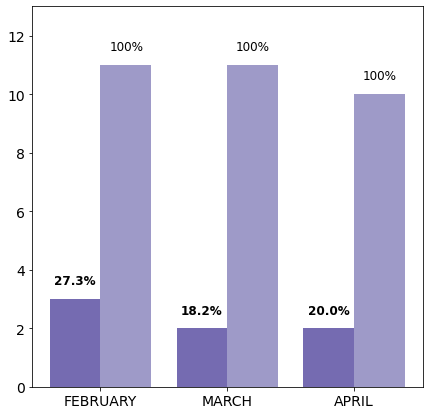

In [465]:
# Requêtes SQL-LID
curseur.execute(
    "SELECT TO_CHAR(dateCommande, 'MONTH') AS Mois, COUNT(numCommande) AS Nb_commandes_defectueuses \
    FROM Commande \
    WHERE numCommande IN ( \
        SELECT numCommande \
        FROM Detail_Commande \
        WHERE quantiteLivree = 0 \
        OR quantiteLivree < quantiteCommandee \
        OR quantiteLivree > quantiteCommandee) \
    GROUP BY TO_CHAR(dateCommande, 'MONTH'), TO_CHAR(dateCommande, 'mm') \
    ORDER BY TO_CHAR(dateCommande, 'mm') ASC") # nombre de commandes défectueuses par mois
donnees = list(curseur)[:] # copie du curseur

curseur.execute(
    "SELECT TO_CHAR(dateCommande, 'MONTH') AS Mois, COUNT(DISTINCT numCommande) AS Nb_commandes_total \
    FROM Commande \
    GROUP BY TO_CHAR(dateCommande, 'MONTH'),TO_CHAR(dateCommande, 'mm') \
    ORDER BY TO_CHAR(dateCommande, 'mm') ASC") # nombre total de commandes par mois
donnees2 = list(curseur)[:] # copie du curseur


# Récupération des données
mois = [mon[0].replace(' ', '') for mon in donnees]
nbCommandes = [cmd[1] for cmd in donnees]  
nbTotalCmd = [tcmd[1] for tcmd in donnees2]
    ##print(donnees, mois, nbCommandes, nbTotalCmd)


# Définition des propriétés visuelles du diagramme en bâton
colormap = plt.get_cmap('tab20c') # palette de couleurs
color1 = colormap(12)
color2 = colormap(13)
    
    
# Initialisation du diagramme en bâton
plt.subplots(figsize=(7, 7)) # création du schéma
plt.ylim(0, 13)
X_axis = np.arange(len(mois))
plt.xticks(X_axis, mois, fontsize=14)
plt.yticks(fontsize=14)

plt.bar(X_axis-0.2, nbCommandes, 0.4, label='Commandes défectueuses', color=color1) # création du diagramme en bâton
plt.bar(X_axis+0.2, nbTotalCmd, 0.4, label='Total de commandes', color=color2)

for i, nbCmd in enumerate(nbCommandes): # pourcentages des bâtons
    pourcentage = str(round((nbCmd/nbTotalCmd[i])*100, 1)) + '%'
    plt.text(i-0.365, nbCmd+0.5, pourcentage, fontweight='bold', fontsize=12)
    plt.text(i+0.07, nbTotalCmd[i]+0.5, '100%', fontsize=12)


# Sauvegarde et affichage du schéma
plt.savefig("graphics/commandesDefectueuses.svg", bbox_extra_artists=(legend,), bbox_inches='tight', transparent=True)
plt.show()